In [1]:
!mkdir -p ~/.kaggle #bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle

In [2]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle

kaggle.json


In [3]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

 99% 1.16G/1.17G [00:06<00:00, 238MB/s]
100% 1.17G/1.17G [00:06<00:00, 200MB/s]


In [4]:
!unzip -q /content/labeled-chest-xray-images.zip -d images

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [6]:
os.listdir('/content/images/chest_xray')

['test', 'train']

In [6]:
main_path= '/content/images/chest_xray'

In [7]:
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')

In [11]:
print('train set: \n' + '='*50)
num_pneumonia= len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal= len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f'jumlah pneumonia= {num_pneumonia}')
print(f'jumlah normal= {num_normal}')

train set: 
jumlah pneumonia= 3883
jumlah normal= 1349


In [9]:
print('test set: \n' + '='*50)
num_pneumonia= len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
num_normal= len(os.listdir(os.path.join(test_dir, 'NORMAL')))
print(f'jumlah pneumonia= {num_pneumonia}')
print(f'jumlah normal= {num_normal}')

test set: 
jumlah pneumonia= 390
jumlah normal= 234


In [8]:
train_normal = glob.glob(train_dir+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_dir+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_dir+"/PNEUMONIA/*.jpeg")

/content/images/chest_xray/train/NORMAL/NORMAL-1003233-0001.jpeg

In [10]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        ##ambil nama dari file \ ke -1
        # images.append(image.split('\')[-1]) 
        # label.append(image.split('\')[-2])
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_normal + train_pneumonia)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

test_df = create_dataframe(test_normal + test_pneumonia)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [11]:
print(train_df.shape)
train_df.head()

(5232, 2)


,images,label
0,/content/images/chest_xray/train/PNEUMONIA/BAC...,PNEUMONIA
1,/content/images/chest_xray/train/PNEUMONIA/BAC...,PNEUMONIA
2,/content/images/chest_xray/train/NORMAL/NORMAL...,NORMAL
3,/content/images/chest_xray/train/NORMAL/NORMAL...,NORMAL
4,/content/images/chest_xray/train/NORMAL/NORMAL...,NORMAL


In [16]:
print(test_df.shape)
test_df.head()

(624, 2)


,images,label
0,/content/images/chest_xray/test/PNEUMONIA/BACT...,PNEUMONIA
1,/content/images/chest_xray/test/NORMAL/NORMAL-...,NORMAL
2,/content/images/chest_xray/test/NORMAL/NORMAL-...,NORMAL
3,/content/images/chest_xray/test/NORMAL/NORMAL-...,NORMAL
4,/content/images/chest_xray/test/PNEUMONIA/VIRU...,PNEUMONIA


In [12]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=1, stratify = train_df['label'])
print(train_df.shape)
print(val_df.shape)

(4185, 2)
(1047, 2)


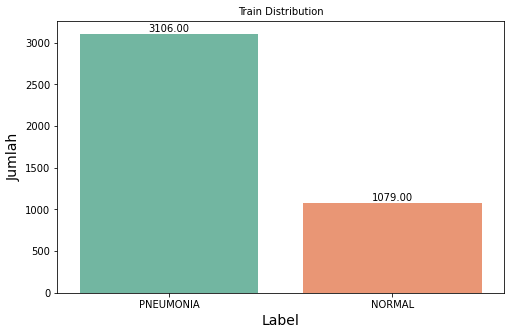

In [13]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of 
    plt.title(f"{label} Distribution", size=10)
    plt.show()

visualize_data(train_df, 'Train')

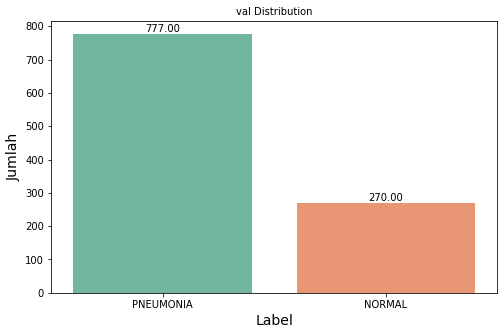

In [19]:
visualize_data(val_df, 'val')

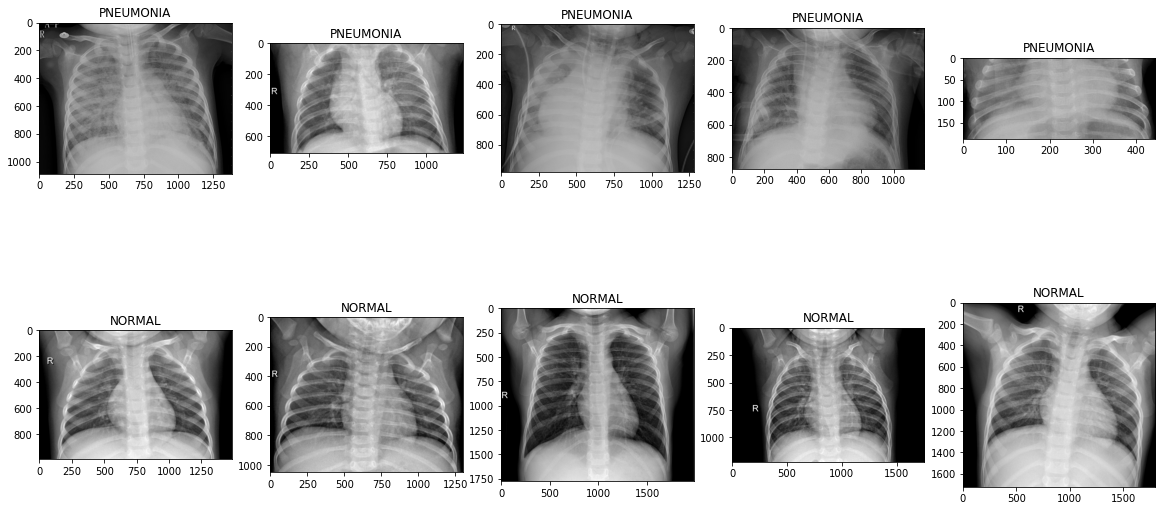

In [14]:
# Get few samples for both the classes
pneumonia_samples = (train_df[train_df['label']=="PNEUMONIA"]['images'].iloc[:5]).tolist()
normal_samples = (train_df[train_df['label']=='NORMAL']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(pneumonia_samples + normal_samples)

In [15]:
img_height= 220
img_width= 220
SEED = 1
BATCH =32

In [16]:
# create image generator

train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
# dari dataframe bukan directory
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width), #ini buat nentuin target biar sama sizenya
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_val = vaL_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

df_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    seed=SEED)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [18]:
ds_train.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Coba aja:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

ref: https://www.tensorflow.org/tutorials/images/classification

In [19]:
callbacks1 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 3), 
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True) # saving the best model
    #ReduceLROnPlateau
]

In [20]:
inputs= [img_height,img_width,3]

my_model_icha= Sequential()

#Conv 1, bisa tambahkan kernel_initializer
my_model_icha.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= inputs))
my_model_icha.add(MaxPooling2D(pool_size=2, strides=2))
# boleh coba dropout dll

#Conv 2
my_model_icha.add(Conv2D(filters=32, kernel_size=3, activation= 'relu'))
my_model_icha.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 3
my_model_icha.add(Conv2D(filters=64, kernel_size=3, activation= 'relu'))
my_model_icha.add(MaxPooling2D(pool_size=2, strides=2))

my_model_icha.add(Flatten())
my_model_icha.add(Dense(units= 128, activation='relu'))
my_model_icha.add(Dense(units=1, activation='sigmoid'))

In [21]:
my_model_icha.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 51, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 64)       0

In [22]:
my_model_icha.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

ganti GPU:
- klik menu Runtime
- Ubah jenis Runtime
- Akselerator pilih GPU

catatan : epoch jangan coba 7 aja, bisa coba 20 atau 50

bisa tambahkan di history:

steps_per_epoch=(len(df_train)/BATCH),
validation_steps=(len(ds_val)/BATCH))

In [29]:
history= my_model_icha.fit(ds_train, batch_size= BATCH, 
                           epochs= 7, validation_data= ds_val,
                           callbacks= callbacks1) #bisa atur verbose

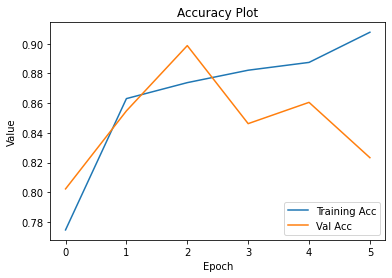

In [24]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

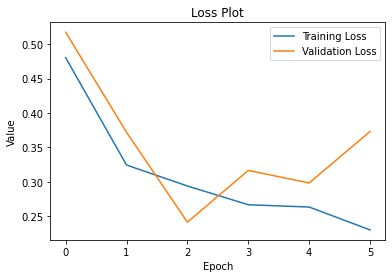

In [25]:
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [26]:
val_results = my_model_icha.evaluate(ds_val, verbose=0)
print(f'Validation Loss     : {val_results[0]:.4f}')
print(f'Validation Accuracy : {val_results[1]:.4f}')

Validation Loss     : 0.3731
Validation Accuracy : 0.8233


In [ ]:
# transfer learning

# callback2
callbacks2 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 4), 
    ModelCheckpoint('model_best2.hdf5', monitor='val_loss', save_best_only=True) # saving the best model
]

pretrained_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', \
                                                  input_shape=inputs, pooling='avg')
pretrained_model.trainable = False

In [ ]:
# Create the model
model_cindra = Sequential()
model_cindra.add(pretrained_model)
model_cindra.add(Flatten())
model_cindra.add(Dense(128, activation='relu'))
model_cindra.add(Dense(128, activation='relu'))
model_cindra.add(Dense(1, activation='sigmoid'))

In [ ]:
model_cindra.summary()

In [ ]:
model_cindra.compile(optimizer='adamax', loss='binary_crossentropy', metrics= ['accuracy'])

In [ ]:
history2 = model_cindra.fit(ds_train, batch_size= BATCH, 
                           epochs= 9, validation_data= ds_val,
                           callbacks= callbacks1, 
                           steps_per_epoch=(len(df_train)/BATCH),
                           validation_steps=(len(ds_val)/BATCH)) )

# testing

Saving download.jpeg to download.jpeg


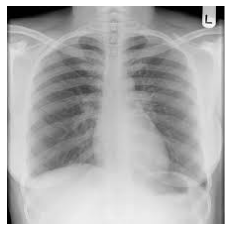

[[1.]]
pneumonia


In [28]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = image.load_img(path, target_size=(220,220))
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = image.img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = my_model_icha.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] == 1:
    print('pneumonia')
  else:
    print('normal')

ada cara buat gunain dari data testing, tapi cari sendiri